# Create Figure 1 for PTEN

This notebook creates a histogram that shows the different PTEN mutations found in 9 cancers.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import plot_utils as ut

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Step 1: Create data frames with Mutation Types

For each cancer type, create a data frame that has the mutation type for each sample.

First, load in the cancer data sets from cptac.

In [3]:
en = cptac.Endometrial()
hn = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
c = cptac.Ccrcc()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()

version 3scc v3.2.......                        


In [4]:
def plot_mutations(dflist = None, names_of_df=None):
    number_of_df = len(dflist)
    
    allLabels = []
    for df in dflist:
        #get the labels for each and make a combined label that they'll all use
        mutation = df["Mutation"]
        labels = set(mutation)
        allLabels.append(labels)

    
    flat_list = [item for sublist in allLabels for item in sublist]
    all_labels = list(set(flat_list))
    all_labels.sort()
    allLabels = all_labels
    
#     For each df, add na to their labels if it doesn't exist in all_labels
    labels_for_each_df = []
    frequencies_for_each_df = []
    for df in dflist:
        mutation = df["Mutation"].tolist()
        mutationlist = list(set(mutation))
        mutationlist.sort()
        ordered_mut_list = []
        match = True
        mutPosition = 0
        
        for position in range(len(all_labels)):
            try:
                
                if mutationlist[mutPosition] == all_labels[position]:
                    ordered_mut_list.append(mutationlist[mutPosition])
                    mutPosition += 1

                else:
                    ordered_mut_list.append("na")

            except IndexError:  
                ordered_mut_list.append("na")
       
        
        labels_for_each_df.append(ordered_mut_list)

        #get the freq of each mutation type
        freq = []
        for mutation_type in ordered_mut_list:
            freq.append(mutation.count(mutation_type))

        PercentFreq = [x*100 / sum(freq) for x in freq]
        frequencies_for_each_df.append(PercentFreq)
        
        
    #Now plot it using arrays
    width = 0.1
    x = np.arange(len(allLabels))
    a4_dims = (11, 6) #dimensions for bigger plot
    fig, ax = plt.subplots(figsize=a4_dims)
    for position in range(0, number_of_df):
        r = ax.bar(x+(width*position), frequencies_for_each_df[position], width,label=names_of_df[position], alpha=.5, linewidth=0)
        
    
    ax.set_xticks(x)
    ax.set_xticklabels(allLabels, size = 15)
    ax.set_ylabel('Percent Sample', size = 20)
    ax.yaxis.set_tick_params(labelsize=17)
    plt.ylim(0, 100)
    ax.legend(prop={'size': 15})
    

    fig.tight_layout()
    plt.setp(ax.get_xticklabels(),rotation=45)
    plt.show()
    
    #save fig
    fig.savefig("Step_1_PTEN.png", bbox_inches="tight", dpi = 300)
    

Second, call get_geneotype_all_vars for PTEN for each cancer type. This returns a df with columns for Mutation (type of mutation), Location (location of the mutation), and Mutation_Status (wildtype or mutation count).

In [5]:
gene = "PTEN"

In [6]:
endo = en.get_genotype_all_vars(gene)
gbm = g.get_genotype_all_vars(gene)
hnscc = hn.get_genotype_all_vars(gene)
ovar = o.get_genotype_all_vars(gene)
cc = c.get_genotype_all_vars(gene)
colon = col.get_genotype_all_vars(gene)
ld = l.get_genotype_all_vars(gene)
lscc = ls.get_genotype_all_vars(gene)
brca = b.get_genotype_all_vars(gene)

In [7]:
#test
endo.head()

Name,Mutation,Location,Mutation_Status
Patient_ID,,,
C3L-00006,Nonsense_Mutation,p.R233*,Multiple_mutation
C3L-00008,Missense_Mutation,p.G127R,Single_mutation
C3L-00032,Nonsense_Mutation,p.W111*,Single_mutation
C3L-00090,Missense_Mutation,p.R130G,Multiple_mutation
C3L-00098,Wildtype_Tumor,No_mutation,Wildtype_Tumor


In [8]:
# Simplify mutation names
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc, cc]
for df in dfs:
    df['Mutation'].where(df['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replaces when false
    df['Mutation'].where(df['Mutation'] != 'Wildtype_Tumor', 'Wildtype', inplace = True)
endo.head()

Name,Mutation,Location,Mutation_Status
Patient_ID,,,
C3L-00006,Nonsense_Mutation,p.R233*,Multiple_mutation
C3L-00008,Missense,p.G127R,Single_mutation
C3L-00032,Nonsense_Mutation,p.W111*,Single_mutation
C3L-00090,Missense,p.R130G,Multiple_mutation
C3L-00098,Wildtype,No_mutation,Wildtype_Tumor


In [9]:
colon.Mutation.value_counts()

Wildtype               76
Deletion               25
nonsynonymous SNV       3
frameshift deletion     1
Amplification           1
Name: Mutation, dtype: int64

# Step 2: Match Mutation Labels

The Colon dataset labeled their mutations slightly differently. Nonsynonymous snv in this case is a missense mutation. Nonframeshift insertion was changed to match In_Frame_Ins. Frameshift deletion was canged to match Frame_Shift_Del.

In [10]:
colon["Mutation"] = colon['Mutation'].replace(['nonsynonymous SNV'], 'Missense')

colon["Mutation"] = colon['Mutation'].replace(['nonframeshift insertion'], 'In_Frame_Ins')

colon["Mutation"] = colon['Mutation'].replace(['frameshift deletion'], 'Frame_Shift_Del')

In [11]:
colon.Mutation.value_counts()

Wildtype           76
Deletion           25
Missense            3
Frame_Shift_Del     1
Amplification       1
Name: Mutation, dtype: int64

In [12]:
#combine to make indel mutation type 
lscc["Mutation"] = lscc['Mutation'].replace(['In_Frame_Del'], 'In_Frame_Indel')

#combine to make truncation muatation type
nonsense = [endo, ovar, cc, brca, lscc]
for df in nonsense:
    df["Mutation"] = df['Mutation'].replace(['Nonsense_Mutation'], 'Truncating') 
    
frame_shift_del = [endo, ovar, colon, brca, lscc]
for df in frame_shift_del:
    df["Mutation"] = df['Mutation'].replace(['Frame_Shift_Del'], 'Truncating')
    
frame_shift_ins = [endo]
for df in frame_shift_ins:
    df["Mutation"] = df['Mutation'].replace(['Frame_Shift_Ins'], 'Truncating')

The get_genotype_all_var function created the No_Mutation label when no somatic mutations were found for PTEN in the Luad dataset. This is the same as Wildtype_Tumor. 

In [13]:
ld["Mutation"] = ld['Mutation'].replace(['No_Mutation'], 'Wildtype')

# Step 3: Create Figure

Create a list of the mutation data frames. Create a list of cancer names for the figure legend. Call the plot_mutations function.

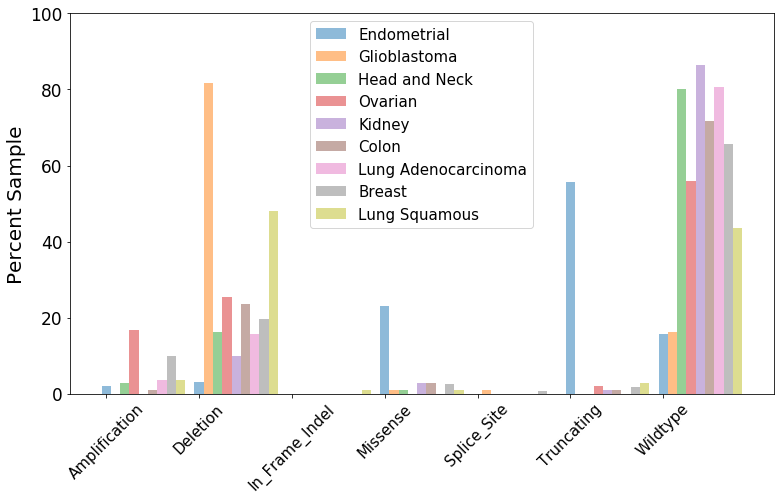

In [14]:
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Kidney', 'Colon', 'Lung Adenocarcinoma', 'Breast', 
         'Lung Squamous']
plot_mutations(dfs, names)

In [15]:
cancer_dfs = {'Endo':endo, 'Gbm':gbm, 'Hnscc':hnscc, 'Ov':ovar, 'K':cc, 'Colon':colon, 
              'Luad':ld, 'Brca':brca, 'Lscc':lscc}
for cancer in cancer_dfs:
    df = cancer_dfs[cancer]
    vc = df.Mutation.value_counts()
    total = len(df)
    cnv_del = vc.Deletion
    print(cancer)
    print('total_samples:',total,'\n')
    #print(vc, '\n')
    print(cnv_del,'/',total,'=', cnv_del/total,'\n')

Endo
total_samples: 95 

3 / 95 = 0.031578947368421054 

Gbm
total_samples: 99 

81 / 99 = 0.8181818181818182 

Hnscc
total_samples: 111 

18 / 111 = 0.16216216216216217 

Ov
total_samples: 102 

26 / 102 = 0.2549019607843137 

K
total_samples: 110 

11 / 110 = 0.1 

Colon
total_samples: 106 

25 / 106 = 0.2358490566037736 

Luad
total_samples: 109 

17 / 109 = 0.1559633027522936 

Brca
total_samples: 122 

24 / 122 = 0.19672131147540983 

Lscc
total_samples: 108 

52 / 108 = 0.48148148148148145 

